In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Imorting dataset from kaggle

In [ ]:
# generating dataset from directory

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = '/content/drive/MyDrive/shagundeep/dataset/Normal_DiabeticRetinopathy',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 2179 files belonging to 2 classes.


In [ ]:
labels = np.concatenate([y for x,y in data], axis=0)
values = pd.value_counts(labels)
values = values.sort_index()

In [ ]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = diabetic_retinopathy, 1 = normal, 

#Visualizing the data

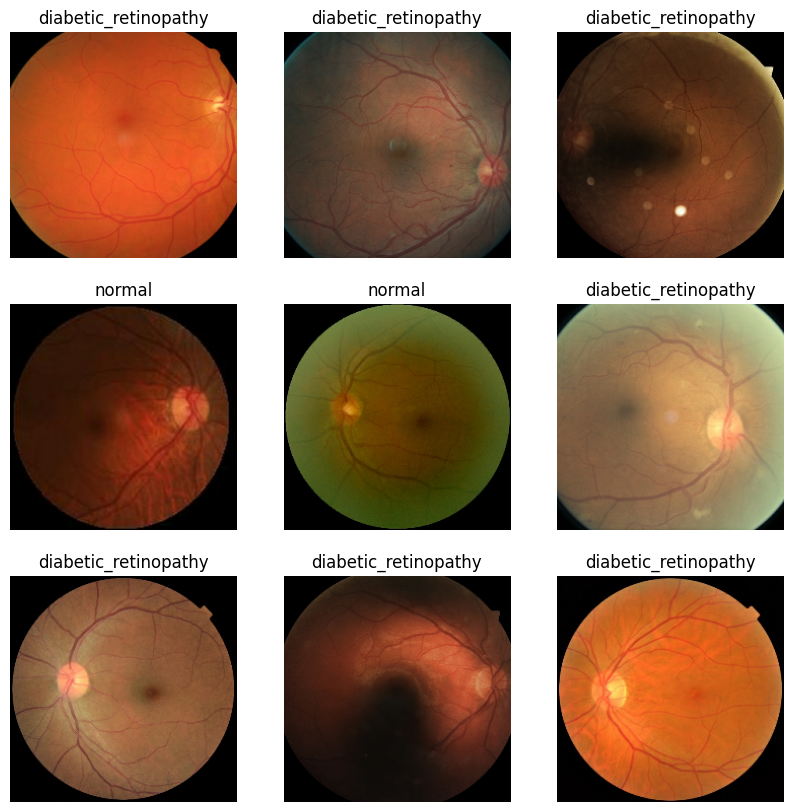

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Preprocessing data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
# sns.heatmap(batch[0][1][:,:,1])

In [ ]:
sample = data.as_numpy_iterator().next()

In [ ]:
print("Minimum value of the scaled data:", sample[0].min())
print("Maximum value of the scaled data:", sample[0].max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [ ]:
print("There are", len(data), "batches in our data")

There are 35 batches in our data


Splitting the dataset

In [ ]:
train_size = int(len(data)*0.70)+1
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)


Train Size: 25
Validation Size: 7
Test Size: 3


In [ ]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

Preparing the dataset

In [ ]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [ ]:
y_true = test_set['labels']

Resnet

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(include_top=True,
                                            input_shape=(224,224)+(3,),
                                            weights= 'imagenet')
model = Sequential()
# model.add(data_augmentation)
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='softmax'))

model.layers[0].trainable = False


In [ ]:
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten_3 (Flatten)         (None, 1000)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 25,642,714
Trainable params: 4,002
Non-trainable params: 25,638,712
______________________________________

In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs = 100,
    # callbacks = EarlyStopping(monitor='loss', patience=5)
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 15s 426ms/step - loss: 0.6959 - accuracy: 0.5013 - val_loss: 0.6937 - val_accuracy: 0.5045
Epoch 2/100
25/25 [==============================] - 11s 401ms/step - loss: 0.6909 - accuracy: 0.5344 - val_loss: 0.6939 - val_accuracy: 0.4844
Epoch 3/100
25/25 [==============================] - 10s 384ms/step - loss: 0.6949 - accuracy: 0.5019 - val_loss: 0.6936 - val_accuracy: 0.4978
Epoch 4/100
25/25 [==============================] - 11s 398ms/step - loss: 0.6931 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.4688
Epoch 5/100
25/25 [==============================] - 11s 398ms/step - loss: 0.6946 - accuracy: 0.5106 - val_loss: 0.6922 - val_accuracy: 0.5246
Epoch 6/100
25/25 [==============================] - 10s 377ms/step - loss: 0.6930 - accuracy: 0.5213 - val_loss: 0.6941 - val_accuracy: 0.4933
Epoch 7/100
25/25 [==============================] - 10s 383ms/step - loss: 0.6928 - accuracy: 0.5188 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoc

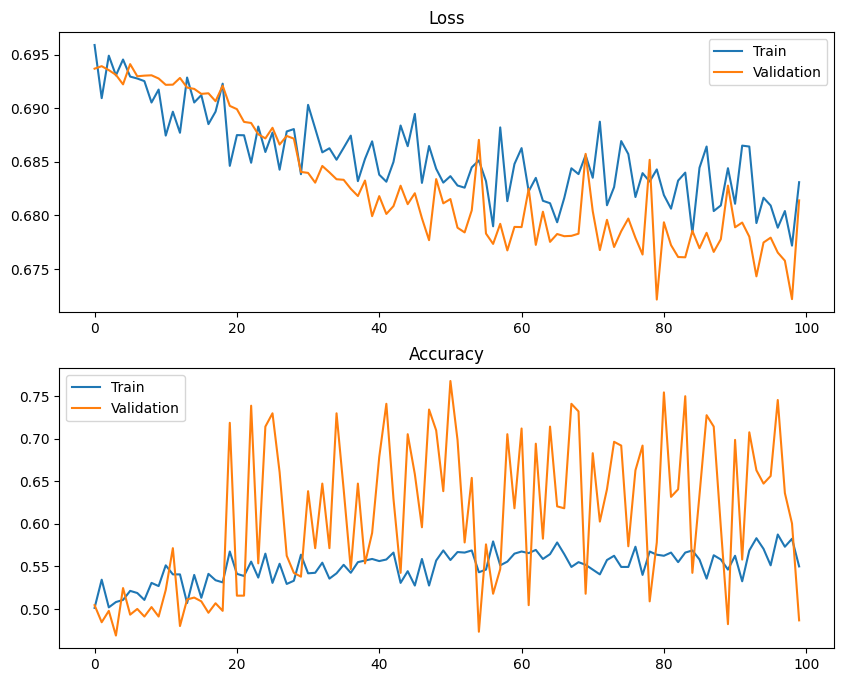

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history.history["loss"], label="Train")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train")
ax[1].plot(history.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()


In [ ]:
y_true

array([0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.])

In [ ]:

y_pred = np.argmax(model.predict(test_set['images']), 1)

5/5 [==============================] - 2s 204ms/step


In [ ]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
#y_pred_prob = np.argmax(model.predict_proba(test_set['images']), 1)

def predict_prob(number):
  return [number[0],1-number[0]]

y_prob = np.array(list(map(predict_prob, model.predict(test_set['images']))))
y_prob = y_prob[::,1]
y_prob

5/5 [==============================] - 0s 87ms/step


array([0.51289037, 0.51708019, 0.53911221, 0.54770115, 0.55062231,
       0.52643895, 0.52094603, 0.50977227, 0.50903863, 0.51341194,
       0.53355691, 0.51358745, 0.56766722, 0.51423204, 0.51751411,
       0.52963108, 0.51430443, 0.51348355, 0.51914665, 0.51936629,
       0.53594387, 0.52981922, 0.52302155, 0.55646238, 0.51760155,
       0.51920187, 0.55185962, 0.51057011, 0.52176684, 0.52264053,
       0.58362845, 0.51063001, 0.52928701, 0.51252025, 0.51363888,
       0.58818516, 0.58415529, 0.53331423, 0.56897891, 0.55350983,
       0.53056377, 0.54316136, 0.51912457, 0.51602271, 0.51779389,
       0.51295343, 0.55413634, 0.55238867, 0.51506856, 0.51697206,
       0.53445935, 0.57390061, 0.51203203, 0.5186995 , 0.51088628,
       0.51488751, 0.53232616, 0.52989766, 0.56648237, 0.51895258,
       0.55263969, 0.53183857, 0.5176447 , 0.52590325, 0.5317761 ,
       0.55808017, 0.51495719, 0.52345732, 0.59054995, 0.58307052,
       0.51227924, 0.51871765, 0.52916199, 0.54585505, 0.50781

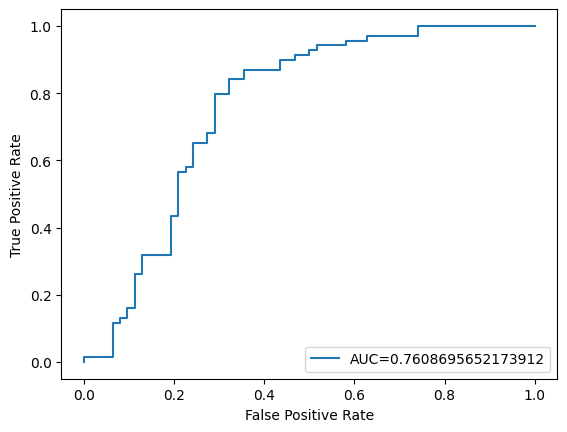

In [ ]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_true,  y_prob)
auc = metrics.roc_auc_score(y_true,  y_prob)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()



In [ ]:
pip install sklearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

                      precision    recall  f1-score   support

diabetic_retinopathy       0.00      0.00      0.00        62
              normal       0.53      1.00      0.69        69

            accuracy                           0.53       131
           macro avg       0.26      0.50      0.35       131
        weighted avg       0.28      0.53      0.36       131



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

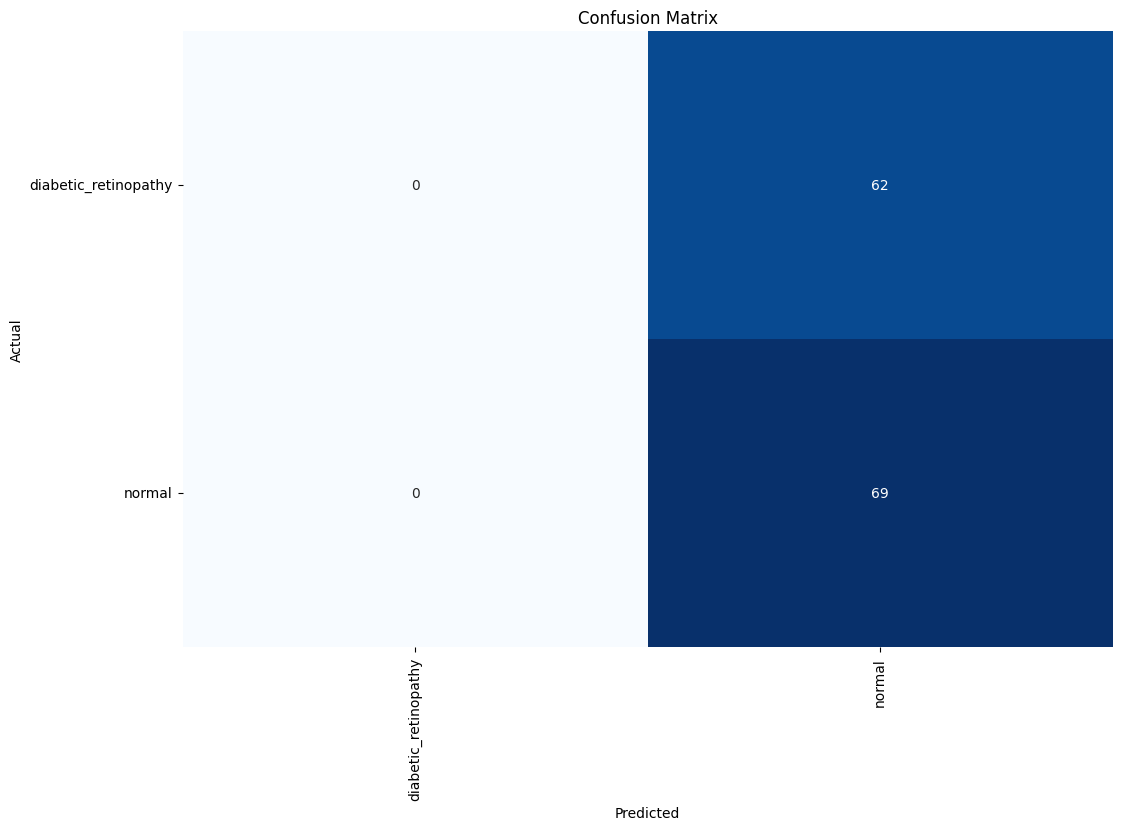

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2)+.5, class_names, rotation=90)
plt.yticks(np.arange(2)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [ ]:
sensitivity = np.diag(cm)/np.sum(cm,axis=1)
specificity = []
for i in range(cm.shape[0]):
  tn = np.delete(cm, i ,axis=0)[:,np.delete(np.arange(cm.shape[0]),i)]
  fp = np.delete(cm[i:],i)
  specificity.append(np.sum(tn)/ (np.sum(tn)+np.sum(fp)))

<ipython-input-97-8c6857495bec>:6: RuntimeWarning: invalid value encountered in long_scalars
  specificity.append(np.sum(tn)/ (np.sum(tn)+np.sum(fp)))


In [ ]:
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)

In [ ]:
print(f'Overall Sensitivity: {overall_sensitivity}')
print(f'Overall Specficity: {overall_specificity}')

Overall Sensitivity: 0.5
Overall Specficity: nan
